<h1>Monte Carlo Simulations of Ising Model 2D</h1>

<p>As a start let us briefly summarize the Ising Model. The model have the following Hamiltonian:
    $$ H(\sigma) = -\sum_{<i,j>} J_{ij}\sigma_i \sigma_j - h\sum_j \sigma_j$$ and the magnetizations is defined to be:
    $$ m = \frac{1}{N} \sum_i \sigma_i$$ where $\sigma_i$'s are the spins at site i, $N$ is the total number of sites, $h$ and $J_{ij}$'s are some parameters which will be explained later.</p>

<h2>Implementation of the IsingModel Class</h2>
<p>This class will help us easily create Ising Models so that our Monte Carlo Simulations would be easier to implement.</p>

<p>As a reminder for the different values of parameters, the configurations that we may expect is as follows: $$ J_{ij} > 0: \text{ferromagnetic configuration}$$
$$ J_{ij} = 0: \text{non-interacting}$$
$$ J_{ij} < 0: \text{anti-ferromagnetic configuration}$$ and for the other parameter:
$$ h>0: \text{tends to line up in the positive direction}$$
$$ h<0: \text{tends to line up in the negative direction}$$
</p>

<p>We start by importing the libraries and initializing the class. Then we will have some methods for IsingModel objects. Some of the methods will be more generic such as printing the object properly, and some will be more technical such as energy of the object. We will have the following methods:
    <ul>
        <li>Initializing instance</li>
        <li>Plotting the lattice</li>
        <li>Flipping the spin</li>
        <li>Calculate the energy of the spin in one lattice point</li>
        <li>Calculate the critical Temperature</li>
        <li>Calculate magnetization</li>
        <li>Calculate energy of the lattice per spin</li>
        <li>Print all the information about the object</li>
    </ul></p>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random
import pickle as pkl
import imageio
import time
import os

<h3>The constants that should be kept unchanged.</h3>

In [3]:
# This cell is for the variables 
# ----THAT SHOULD NOT BE CHANGED----

MAIN_DIRECTORY = "ising_data"

<h3>The constant values that can be changed.</h3>

In [4]:
# This cell is for the constants that can be changed

# This is the scale we are using 
# in order to prevent floating 
# point errors in temperature values
# Below is a default value

TEMPERATURE_SCALE = 1000

# The seed we are using
SEED = 1001



<h3>Before doing anything, let us first check if the random number generator that will be used is uniform.</h3>

<p>Below we can see that in fact it is uniform to the human eyes.</p>

[3626. 1741. 3700. ...  910. 2571. 2748.]
[2400. 1852.  162. ... 2360. 1051. 3274.]


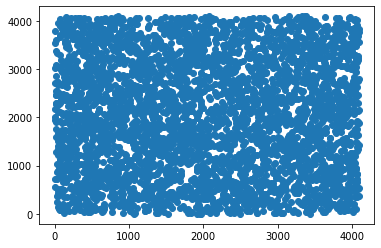

In [5]:
a = np.zeros(4096)
b = np.zeros(4096)
for i in np.arange(a.size):
    a[i], b[i] = random.getrandbits(12), random.getrandbits(12)
print(a)
print(b)
plt.scatter(a,b)

[1066. 1097. 4907. ... 2548. 4693.  331.]
[4688. 4622. 2928. ... 2646. 3498. 3713.]


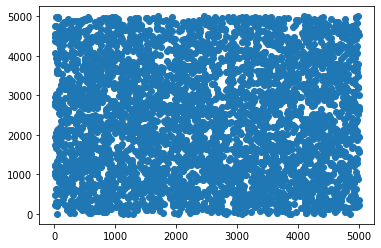

In [10]:
a = np.zeros(4096)
b = np.zeros(4096)
for i in np.arange(a.size):
    a[i], b[i] = int(5000 * random.random()), int(5000 * random.random())
print(a)
print(b)
plt.scatter(a,b)

<h3>And also let us check if the same seed generates the same number.</h3>

<p>If we run the cell below over and over again, we will see it generates the same result. Therefore our seed also works.</p>

In [5]:
random.seed(SEED)
print(random.getrandbits(5)) # Generates 5 bits i.e. generates in the (0,32) interval
print(random.getrandbits(6)) # Generates 6 bits i.e. generates in the (0,64) interval
print(random.getrandbits(7)) # Generates 7 bits i.e. generates in the (0,128) interval

25
59
7


In [6]:
np.random.seed(SEED)
np.random.randint(6)

5

<h3>Now we can start writing our IsingLattice class</h3>

In [7]:
class IsingLattice:
    
    # Initializer. Parameter n corresponds to the lattice size. 
    
    def __init__(self,lattice_size,J,h):
        
        # In order to easily access the parameters: 
        self.lattice_size = lattice_size
        self.num_sites = lattice_size*lattice_size
        self.J = J
        self.h = h
        
        # We randomly initialize the lattice with 0's and 1's
        lattice_state = np.random.choice([1,-1],size=(self.lattice_size,self.lattice_size))
        
        # We store the configuration 
        self.lattice_state = lattice_state
    
    # The Methods 
    # Plot function. This will help us easily see the lattice configuration.
    
    def plot_lattice(self, print_info=False): # print_info is Boolean. If it is true then we print info.
        
        plt.figure()
        plt.imshow(self.lattice_state)
        plt.show()
        if print_info:
            self.print_info()
    
    # Now we define print_info() method. It will print all the information about the lattice.
    
    def print_info(self):
        
        print("Lattice size: ", self.lattice_size , "x", self.lattice_size, ". J: ", self.J, " h: ", self.h )
    
    # A spin flipper at site (i,j) method
    
    def flip_spin(self,i,j):
        self.lattice_state[i,j] *= -1
        
    # Calculating energy of one spin at site (i,j)
        
    def spin_energy(self,i,j):
        
        # Spin at (i,j)
        spin_ij = self.lattice_state[i,j]
        
        # Now we need to deal with the boundary spins. 
        # We apply periodic boundary conditions.  
        sum_neighbouring_spins = self.lattice_state[(i+1)%self.lattice_size, j] + \
                                 self.lattice_state[i, (j+1)%self.lattice_size] + \
                                 self.lattice_state[(i-1)%self.lattice_size, j] + \
                                 self.lattice_state[i, (j-1)%self.lattice_size]
        
        # We calculate the energy terms for site 
        interaction_term = (- self.J * spin_ij * sum_neighbouring_spins)
        
        # This part is added so that in case 
        # there is no external magnetic field, i.e. h = 0
        # then we do not need the computer to do the computation
        # for the magnetic term. 
        if self.h == 0:
            return interaction_term
        else:
            magnetic_field_term = - (self.h * spin_ij)
            return magnetic_field_term + interaction_term
    
    # Calculating Total Lattice Energy
    
    def energy(self):
        
        # Initialize energy as 0.
        E = 0.0
        
        # We iterate through the lattice
        for i in np.arange(self.lattice_size):
            for j in np.arange(self.lattice_size):
                E = E + self.spin_energy(i,j)
                
        # But we counted neighbours twice here. So we need to correctly return. 
        # We divide by two 
        E = E / (2.0) / self.num_sites
        if self.h==0:
            return E
        else: 
            # We add the magnetic field term |IS THERE A 1/2 FACTOR HERE?|
            E = (E - self.h * np.sum(self.lattice_state)) / self.num_sites
            return E
    
    # Net magnetization
    
    def magnetization(self):
        return  np.abs(np.sum(self.lattice_state))/ (self.num_sites)
        

In [83]:
test = IsingLattice(64,1,0)

In [84]:
test.lattice_state

array([[-1,  1,  1, ..., -1,  1,  1],
       [ 1,  1, -1, ...,  1,  1,  1],
       [ 1,  1, -1, ..., -1,  1,  1],
       ...,
       [-1,  1, -1, ...,  1, -1,  1],
       [ 1, -1,  1, ..., -1,  1, -1],
       [ 1, -1,  1, ..., -1, -1, -1]])

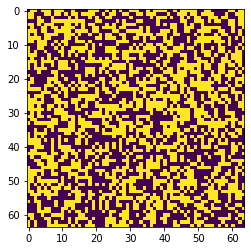

Lattice size:  64 x 64 . J:  1  h:  0


In [85]:
test.plot_lattice(print_info=True)

In [86]:
print(test.spin_energy(10,10))

4


In [87]:
print(test.energy())

-0.0244140625


In [88]:
test.flip_spin(10,10)

In [89]:
print(test.spin_energy(10,10))

-4


<h2>Metropolis Algorithm</h2>

<p>Now that we can see that the IsingModel class works, we can focus on the Metropolis Algorithm step. First we create a method to scan the lattice and make a decision on whether to flip spins one by one. Then we write the main Metropolis method. Below we can see the flowchart explaining the Metropolis algorithm.</p>
<img src="metropolis_flowchart.png" width="50%" height="50%">

<h3>Up until this point, we did the following steps succesfully: we have the lattice inputs, we generated random lattice. Next we will iterate randomly over the matrix and flip spins according to the Metropolis Criteria.</h3>

In [10]:
# Boltzmann constant is fixed to 1.

def scan_lattice(ising_lattice, T):
    
    for k in np.arange(ising_lattice.num_sites):
        # We choose a random site
        lattice_size_power = int(np.log2(ising_lattice.lattice_size))
        i = random.getrandbits(lattice_size_power)
        j = random.getrandbits(lattice_size_power)

        
        # We calculate the energy difference if we flip
        E_initial = ising_lattice.spin_energy(i,j)
        ising_lattice.flip_spin(i,j)
        E_final = ising_lattice.spin_energy(i,j)
        delta_E = E_final - E_initial
        
        # For convenience we flip it back to the original
        ising_lattice.flip_spin(i,j)
        
        # Then we should flip the spin
        
        if delta_E<0 or np.random.rand()<np.exp(-delta_E/T):
            # If the Metropolis Criteria holds, swap. 
            ising_lattice.flip_spin(i,j)
    

<h3>Now that we have the methods to do the scan, we can collect the data. The whole process will be one method. We will basically do the Monte-Carlo Simulation in the next method using the above scan_lattice. We will collect the data we need.</h3>

In [11]:
def monte_carlo_simulation(ising_lattice, T, num_scans, num_scans_4_equilibrium, frequency_sweeps_to_collect_magnetization, plot_result = False,print_info=False):
    start_time = time.time()
    
    # The first three arguments are self-explanatory. 
    # The last one is the number of scans we need to do
    # Before we reach equilibrium. Therefore we do not
    # need to collect data at these steps. 
    if print_info:
        ising_lattice.print_info()
    
    # We start by collecting <E> and <m> data. In order to 
    # calculate these, we record energy and magnetization 
    # after we reach equilibrium.
    
    # The total number of records, both first and last point included
    TOTAL_NUM_RECORDS = int(num_scans/frequency_sweeps_to_collect_magnetization)+1
    energy_records = np.zeros(TOTAL_NUM_RECORDS)
    magnetization_records = np.zeros(TOTAL_NUM_RECORDS)
    increment_records = 0
    
    # We will return this n-dimensional 
    lattice_configs = np.zeros((TOTAL_NUM_RECORDS,\
                               ising_lattice.lattice_size,\
                               ising_lattice.lattice_size))
    
    for equ in np.arange(num_scans_4_equilibrium):
        scan_lattice(ising_lattice,T)

    for k in np.arange(num_scans):
        scan_lattice(ising_lattice, T)
        if k%frequency_sweeps_to_collect_magnetization==0:
            energy_records[increment_records] = ising_lattice.energy()
            magnetization_records[increment_records] = ising_lattice.magnetization()
            lattice_configs[increment_records] = ising_lattice.lattice_state
            increment_records += 1
    
    # Now we can get the <E> and <m>
    
  
    
    
    print("For T = ", T, "Simulation is executed in: ", " %s seconds " % round(time.time() - start_time,2))
    
    if plot_result:
        ising_lattice.plot_lattice()
    
    
    return lattice_configs, energy_records, magnetization_records

Lattice size:  16 x 16 . J:  1  h:  0
For T =  2.26 Simulation is executed in:   5.73 seconds 


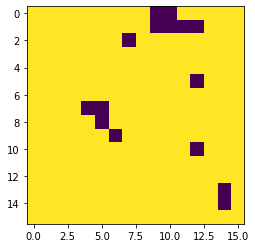

In [12]:
test_lattice, mean_en, mean_m = monte_carlo_simulation(test, 2.26, 1000, 1000, 35, True,True)

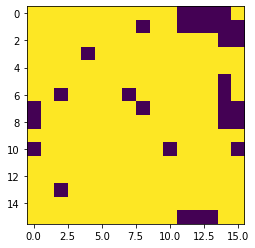

In [13]:
plt.imshow(test_lattice[26])

<h3>Before we collect data, let us create a file name generator so that we can easily write our data into files.</h3>

<p>Below we have the file name generator. We will use this when saving our data.</p>

In [14]:
def file_name(lattice_size,J,h,T,seed):
    return f'SQ_L_{lattice_size}_J_{J:.2f}_h_{h:.2f}_T_{T}_s_{seed}'

<h3>Now let us create the functions to write and read the files.</h3>

In [15]:
def write_to_sub_directory(quantity, file_name):
    
    # Let us check if the path to data exists
    if not(os.path.exists(MAIN_DIRECTORY)):
        os.mkdir(MAIN_DIRECTORY)        
    
    # We change directories accordingly
    os.chdir(MAIN_DIRECTORY)
    if not(os.path.exists(file_name)):
        os.mkdir(file_name)
    os.chdir(file_name)
    
    # Now save with pickle
    file_name_pkl = file_name + ".pkl"
    open_file = open(file_name_pkl,"wb")
    pkl.dump(quantity, open_file)
    open_file.close()
    
    # We go up into the original directory
    os.chdir('..')
    os.chdir('..')

In [16]:
def save_image_to_sub_directory(data, directory_name, file_name):
    
    # Let us check if the path to data exists
    if not(os.path.exists(MAIN_DIRECTORY)):
        os.mkdir(MAIN_DIRECTORY)
    
    # We change directories accordingly
    os.chdir(MAIN_DIRECTORY)
    
    # We check if it exists, if not we make directory
    if not(os.path.exists(directory_name)):
        os.mkdir(directory_name)
    os.chdir(directory_name)
    
    # Now save image
    file_name_img = file_name + ".png"
    imageio.imwrite(file_name_img, data)
    
    # We go up into the original directory
    os.chdir('..')
    os.chdir('..')

<h3>Now we can write the function for data collection.</h3>

<p>Below we define a function to easily collect the data from Monte-Carlo simulations and metropolis algorithm.</p>

In [17]:
def collect_monte_carlo_data(lattice_size,J,h, T_init, T_final, T_increment, num_scans, num_scans_4_equilibrium, frequency_sweeps_to_collect_magnetization):

    print("Lattice size: ", lattice_size , "x", lattice_size, ". J: ", J, " h: ", h , "\n")
    
    # Let's scale it up
    # T array is going to be then
    T = np.arange(T_init*TEMPERATURE_SCALE, (T_final+T_increment)*TEMPERATURE_SCALE, T_increment*TEMPERATURE_SCALE).astype(int)
    
    # Number of samples are calculated
    # since we take one sample for each T
    NUM_SAMPLES = T.size
    
    # Create an array to store average magnetizations
    # with the size NUM_SAMPLES
    mean_magnetizations = np.zeros(NUM_SAMPLES)
    mean_energies = np.zeros(NUM_SAMPLES)
    lattice_configurations = np.zeros((NUM_SAMPLES, lattice_size, lattice_size))

    # We run through T's 
    for i in np.arange(NUM_SAMPLES):
        file_name_lattice = file_name(lattice_size,J,h,T[i],SEED)
        path = MAIN_DIRECTORY + "/" +file_name_lattice
        scale_down_T = T[i]/TEMPERATURE_SCALE
        if os.path.exists(path):
            print("Simulation ", i+1, "/", NUM_SAMPLES, ": ", "T = ", scale_down_T, " Already exists!")
            continue
        print("Simulation ", i+1, "/", NUM_SAMPLES, ": ")
        
        # Each time generate a new random initial lattice configuration
        ising_lattice = IsingLattice(lattice_size, J,h)
        
        # Now we go through with the Monte-Carlo Simulation
        lattice_configs, energy_records, magnetization_records = monte_carlo_simulation(ising_lattice,scale_down_T,num_scans,num_scans_4_equilibrium,frequency_sweeps_to_collect_magnetization)
                
        # We write these down to a file
        # We create a dictionary with the following key-value pairs
        data_sample = {'lattice_configuration' : lattice_configs,
                       'energy' : energy_records,
                       'magnetization' : magnetization_records,
}
        
        write_to_sub_directory(data_sample,file_name_lattice)
        for img in np.arange(lattice_configs.shape[0]):
            save_image_to_sub_directory(lattice_configs[img].astype(np.uint8), file_name_lattice, file_name_lattice+"_n_"+f"%d"% (img*frequency_sweeps_to_collect_magnetization))
        

<h3>We now run this function to collect sample data to test our code.</h3>

<p>We can see that we have generated data succesfully. We generate a directory, under which many subdirectories containing configurations, magnetizations, energies and the image file of the configuration.</p>

In [18]:
SEED=1000
collect_monte_carlo_data(lattice_size = 16 ,
                         J = 1.0 , 
                         h = 0.0 ,
                         T_init = 2.26 ,
                         T_final = 2.35 ,
                         T_increment = 0.01 ,
                         num_scans = 1000 ,
                         num_scans_4_equilibrium = 1000 ,
                         frequency_sweeps_to_collect_magnetization = 50)

Lattice size:  16 x 16 . J:  1.0  h:  0.0 

Simulation  1 / 10 : 
For T =  2.26 Simulation is executed in:   7.16 seconds 
Simulation  2 / 10 : 
For T =  2.27 Simulation is executed in:   7.2 seconds 
Simulation  3 / 10 : 
For T =  2.28 Simulation is executed in:   7.09 seconds 
Simulation  4 / 10 : 
For T =  2.29 Simulation is executed in:   7.11 seconds 
Simulation  5 / 10 : 
For T =  2.3 Simulation is executed in:   7.16 seconds 
Simulation  6 / 10 : 
For T =  2.31 Simulation is executed in:   7.16 seconds 
Simulation  7 / 10 : 
For T =  2.32 Simulation is executed in:   7.1 seconds 
Simulation  8 / 10 : 
For T =  2.33 Simulation is executed in:   7.36 seconds 
Simulation  9 / 10 : 
For T =  2.34 Simulation is executed in:   7.51 seconds 
Simulation  10 / 10 : 
For T =  2.35 Simulation is executed in:   7.25 seconds 
